In [1]:
from keras import layers
from keras import models
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
from keras_preprocessing.image import ImageDataGenerator
import os
import pickle as plk
import pandas as pd
import numpy as np

In [2]:
#check GPU enabled
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
train_dir = 'E:\\CS224S_final_Project\\data\\melspectrograms\\train\\'
dev_dir = 'E:\\CS224S_final_Project\\data\\melspectrograms\\dev\\'
test_dir= 'E:\\CS224S_final_Project\\data\\melspectrograms\\test\\'

In [4]:
example = np.load("E:\\CS224S_final_Project\\data\\melspectrograms\\train\\303_0.npy", allow_pickle=True)
input_dim = example[0].shape
print("input dim:", input_dim)

train_index_to_file = {}
idx = 0
for file in os.listdir(train_dir):
    train_index_to_file[idx] = file
    idx += 1
    
dev_index_to_file = {}
idx = 0
for file in os.listdir(dev_dir):
    dev_index_to_file[idx] = file
    idx += 1
    
test_index_to_file = {}
idx = 0
for file in os.listdir(test_dir):
    test_index_to_file[idx] = file
    idx += 1
    
train_idx = np.array(list(train_index_to_file.keys()))
dev_idx = np.array(list(dev_index_to_file.keys()))
test_idx = np.array(list(test_index_to_file.keys()))
print(train_idx.shape, dev_idx.shape)

input dim: (40, 646)
(3037,) (1154,)


In [5]:
class MelSpectDataGen(Sequence):
    """
    Generates a dataset of log melspectrograms
    """
    def __init__(self, idx, mel_path, idx_to_file,
                 to_fit=True, batch_size=8, dim=input_dim,
                 shuffle=True):
        self.idx = idx
        self.mel_path = mel_path
        self.idx_to_file = idx_to_file
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        """
        numbers of batches per epoch
        """
        return int(np.floor(len(self.idx) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.idx)
    
    def __getitem__(self, index):
        """
        returns one batch of data
        """
        idx = self.idx[index * self.batch_size : (index + 1) * self.batch_size]
        files = [self.idx_to_file[i] for i in idx]
        x, y = self.get_data_from_files(files)
        
        if self.to_fit:
            return x, y
        else:
            return x
    
    def get_data_from_files(self, files):
        x = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, 1))
        
        for i, file in enumerate(files):
            path = os.path.join(self.mel_path, file)
            data = np.load(path, allow_pickle=True)
            x[i,] = self.process_x(data[0])
            y[i,] = data[1]
        
        return x, y
    
    def process_x(self, x):
        #new_x = np.zeros((x.shape[0], x.shape[1]))
        #new_x[:x.shape[0],] = x 

        return x # np.expand_dims(new_x, 2) # create channel size 1
        

In [6]:
# create generators
train_gen = MelSpectDataGen(train_idx, train_dir, train_index_to_file)
dev_gen = MelSpectDataGen(dev_idx, dev_dir, dev_index_to_file)
test_gen = MelSpectDataGen(test_idx, test_dir, test_index_to_file)

In [7]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras import regularizers, optimizers

model = Sequential()
model.add(BatchNormalization(input_shape=input_dim))
model.add(LSTM(500))
model.add(Dense(1, ))
model.compile(optimizers.RMSprop(lr=0.00001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 40, 646)           2584      
_________________________________________________________________
lstm (LSTM)                  (None, 500)               2294000   
_________________________________________________________________
dense (Dense)                (None, 1)                 501       
Total params: 2,297,085
Trainable params: 2,295,793
Non-trainable params: 1,292
_________________________________________________________________


In [8]:
#Fitting keras model, no test gen for now
checkpoint_dir = "E:\\CS224S_final_Project"
checkpoint_path = os.path.join(checkpoint_dir, "cnn_1d_max_pool")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_gen,
                    validation_data=dev_gen,
                    epochs=100,
                    callbacks=[cp_callback])
model.evaluate_generator(generator=dev_gen)

Epoch 1/100


C:\Users\lukes\anaconda3\envs\224s_proj\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


379/379 [==============================] - 7s 13ms/step - loss: 3.0355 - accuracy: 0.7007 - val_loss: 0.7394 - val_accuracy: 0.5295

Epoch 00001: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 2/100
379/379 [==============================] - 4s 10ms/step - loss: 0.6466 - accuracy: 0.6985 - val_loss: 0.7737 - val_accuracy: 0.5582

Epoch 00002: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 3/100
379/379 [==============================] - 4s 10ms/step - loss: 0.6083 - accuracy: 0.7142 - val_loss: 0.7432 - val_accuracy: 0.5460

Epoch 00003: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 4/100
379/379 [==============================] - 4s 10ms/step - loss: 0.5941 - accuracy: 0.7194 - val_loss: 0.7624 - val_accuracy: 0.5599

Epoch 00004: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 5/100
379/379 [==============================] - 4s 10ms/step - loss: 0.5962 - accuracy: 0.7387 - val_loss: 0.7558 - val_accuracy: 0.5399

Epoch 00005

379/379 [==============================] - 4s 10ms/step - loss: 0.1931 - accuracy: 0.9587 - val_loss: 4.3148 - val_accuracy: 0.5347

Epoch 00039: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 40/100
379/379 [==============================] - 4s 10ms/step - loss: 0.2253 - accuracy: 0.9505 - val_loss: 4.4379 - val_accuracy: 0.5399

Epoch 00040: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 41/100
379/379 [==============================] - 4s 10ms/step - loss: 0.1751 - accuracy: 0.9638 - val_loss: 4.4358 - val_accuracy: 0.5521

Epoch 00041: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 42/100
379/379 [==============================] - 4s 10ms/step - loss: 0.2084 - accuracy: 0.9710 - val_loss: 4.7200 - val_accuracy: 0.5382

Epoch 00042: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 43/100
379/379 [==============================] - 4s 10ms/step - loss: 0.1528 - accuracy: 0.9699 - val_loss: 4.7176 - val_accuracy: 0.5382

Epoch 0

379/379 [==============================] - 4s 10ms/step - loss: 0.0596 - accuracy: 0.9931 - val_loss: 5.6360 - val_accuracy: 0.5434

Epoch 00077: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 78/100
379/379 [==============================] - 4s 10ms/step - loss: 0.0759 - accuracy: 0.9935 - val_loss: 5.7192 - val_accuracy: 0.5738

Epoch 00078: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 79/100
379/379 [==============================] - 4s 10ms/step - loss: 0.1099 - accuracy: 0.9897 - val_loss: 5.5965 - val_accuracy: 0.5417

Epoch 00079: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 80/100
379/379 [==============================] - 4s 10ms/step - loss: 0.1185 - accuracy: 0.9889 - val_loss: 5.6761 - val_accuracy: 0.5651

Epoch 00080: saving model to E:\CS224S_final_Project\cnn_1d_max_pool
Epoch 81/100
379/379 [==============================] - 4s 10ms/step - loss: 0.0558 - accuracy: 0.9921 - val_loss: 5.6951 - val_accuracy: 0.5434

Epoch 0

C:\Users\lukes\anaconda3\envs\224s_proj\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[5.862860679626465, 0.5416666865348816]

In [9]:
model.evaluate_generator(generator=test_gen)

[4.607485771179199, 0.6129441857337952]

In [13]:
history.history

{'loss': [0.5970097184181213,
  0.5864580869674683,
  0.5733625292778015,
  0.5593507289886475,
  0.5499074459075928,
  0.529107928276062,
  0.5039184093475342,
  0.49000266194343567,
  0.4611984193325043,
  0.4361407458782196,
  0.4101009964942932,
  0.3861428201198578,
  0.3670750558376312,
  0.3522728979587555,
  0.3325035870075226,
  0.3121224343776703,
  0.2907268702983856,
  0.2930213212966919,
  0.2721068859100342,
  0.2542506158351898,
  0.2511141002178192,
  0.2314685732126236,
  0.22735288739204407,
  0.22089965641498566,
  0.20902900397777557,
  0.1775413602590561,
  0.18083719909191132,
  0.1746797114610672,
  0.17320701479911804,
  0.15977928042411804],
 'accuracy': [0.7194675803184509,
  0.7171381115913391,
  0.7174708843231201,
  0.720798671245575,
  0.728723406791687,
  0.7400998473167419,
  0.7527454495429993,
  0.7650582194328308,
  0.7763727307319641,
  0.7946755290031433,
  0.8053244352340698,
  0.8282861709594727,
  0.8296173214912415,
  0.841930091381073,
  0.8552

In [14]:
output = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)

In [21]:
history.history['val_accuracy']

[0.5980902910232544,
 0.5980902910232544,
 0.5972222089767456,
 0.5963541865348816,
 0.5642361044883728,
 0.5078125,
 0.484375,
 0.5295138955116272,
 0.5251736044883728,
 0.4869791567325592,
 0.5130208134651184,
 0.484375,
 0.5199652910232544,
 0.5138888955116272,
 0.4756944477558136,
 0.4600694477558136,
 0.5269097089767456,
 0.4904513955116272,
 0.5182291865348816,
 0.4131944477558136,
 0.5199652910232544,
 0.4756944477558136,
 0.4600694477558136,
 0.4921875,
 0.4505208432674408,
 0.5355902910232544,
 0.5486111044883728,
 0.5234375,
 0.4635416567325592,
 0.4609375]

In [18]:
output

[1.459011435508728, 0.4618055522441864]

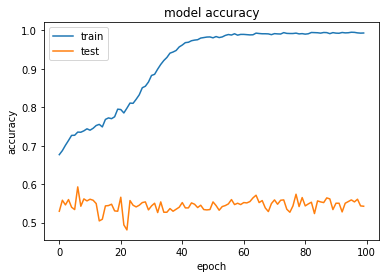

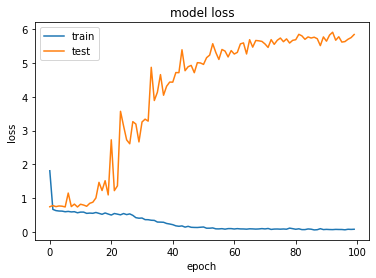

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
history.history

{'loss': [0.5970097184181213,
  0.5864580869674683,
  0.5733625292778015,
  0.5593507289886475,
  0.5499074459075928,
  0.529107928276062,
  0.5039184093475342,
  0.49000266194343567,
  0.4611984193325043,
  0.4361407458782196,
  0.4101009964942932,
  0.3861428201198578,
  0.3670750558376312,
  0.3522728979587555,
  0.3325035870075226,
  0.3121224343776703,
  0.2907268702983856,
  0.2930213212966919,
  0.2721068859100342,
  0.2542506158351898,
  0.2511141002178192,
  0.2314685732126236,
  0.22735288739204407,
  0.22089965641498566,
  0.20902900397777557,
  0.1775413602590561,
  0.18083719909191132,
  0.1746797114610672,
  0.17320701479911804,
  0.15977928042411804],
 'accuracy': [0.7194675803184509,
  0.7171381115913391,
  0.7174708843231201,
  0.720798671245575,
  0.728723406791687,
  0.7400998473167419,
  0.7527454495429993,
  0.7650582194328308,
  0.7763727307319641,
  0.7946755290031433,
  0.8053244352340698,
  0.8282861709594727,
  0.8296173214912415,
  0.841930091381073,
  0.8552